# Evolution of red sequence on WaZP DP0 clusters

### Andressa Wille 

#### Universidade Tecnológica Federal do Paraná (UTFPR)
#### Laboratório Interinstitucional de e-Astronomia (LIneA)


___________________________________________________________________________________
To-do:

    * Incluir plots QA vacs
    * Arrumar o expected_params.txt para os bins de richness
    * Adicionar seção de Future Works com a análise inicial da red slope
    * Verificar quais bibliotecas nos imports não são necessárias e adicionar a table_io

## Objectives & Research Question:
* Study the red fraction evolution of members of WaZP clusters on DP0;
* Evaluate the performance of the WaZP algorithm, depending on input data;
* What is the impact of photo-z uncertainties on the red sequence evolution?  

## Background:
The Wavelet Z Photometric (WaZP) is an optical cluster finder that detects clusters using photometric redshift information. The algorithm can be used to select cluster members to study different aspects in cluster evolution, as the color-magnitude diagram feature named red sequence.


## Methodology:

Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pylab as pl
import scipy.stats as stats
from astropy.table import Table
import pandas as pd
from scipy.optimize import curve_fit
import sys
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.integrate import quad
from scipy.special import erf
import sqlalchemy
from gavodb import DBManager

%matplotlib inline

### VAC QAs:

Processes on DES Science Portal:

| Pipeline | Product Log|
|---|:--:|
| Photo-z Training   | [7028](https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7028) |
| Photo-z Compute    | [7030](https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7030) |
| VAC DP0            | [7032](https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7032) |
| VAC DC2            | [7011](https://des-portal.linea.org.br/VP/getViewProcessCon?process_id=7011) |


In [2]:
dbm = DBManager()

#### Photo-z compute

In [5]:
photoz_comp = dbm.get_tablelist_from_pid('7030')

In [6]:
photoz_comp

['photoz_compute.dnf_7030']

In [7]:
columns = ['z_best']
photoz = dbm.get_db_table('photoz_compute.dnf_7030', columns)

In [8]:
photoz = pd.DataFrame(data=photoz)
photoz = photoz.T
photoz.columns = ['z_best']
photoz

,z_best
0,14.136397
1,0.642072
2,1.523735
3,0.910847
4,0.612456
...,...
147088473,0.938458
147088474,1.753673
147088475,1.034884
147088476,1.012873


#### VAC DC2

In [ ]:
vac_dc2_tables = dbm.get_tablelist_from_pid('7011')

In [ ]:
vac_dc2_tables

In [ ]:
vac_dc2 = dbm.get_db_table('vac_cluster_simulation.footprint_7011', ['ra', 'dec'])

In [ ]:
vac2_dc2 = dbm.get_db_table('vac_cluster_simulation.catalog_7011', ['ra', 'dec', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y'])

In [ ]:
vac_dc2

In [ ]:
vac_dataframe = pd.DataFrame(data=vac_dc2)

In [ ]:
vac_dataframe = vac_dataframe.T

In [ ]:
vac_dataframe.columns = ['ra', 'dec']

In [ ]:
dc2 = vac_dataframe
dc2

#### DP0

In [3]:
vac_dp0_tables = dbm.get_tablelist_from_pid('7032')
vac_dp0_tables

['vac_cluster_simulation.footprint_7032',
 'vac_cluster_simulation.catalog_7032']

In [4]:
vac_dp0 = dbm.get_db_table('vac_cluster_simulation.catalog_7032', ['mag_i'])

In [5]:
vac_dp0 = pd.DataFrame(data=vac_dp0)
vac_dp0 = vac_dp0.T
vac_dp0.columns = ['mag_i']
vac_dp0

,mag_i
0,24.6127
1,24.5674
2,23.8648
3,20.2563
4,24.3477
...,...
74737545,24.9591
74737546,23.1483
74737547,21.2837
74737548,23.1260


#### Photo-z x spec-z

In [ ]:
plt.plot(dc2['z_photo'], dc2['z_spec'], 'k.')
plt.xlabel("photo-z")
plt.ylabel("spec-z")
plt.title("Redshift")
plt.grid(True)
plt.tight_layout()

#### N(z)

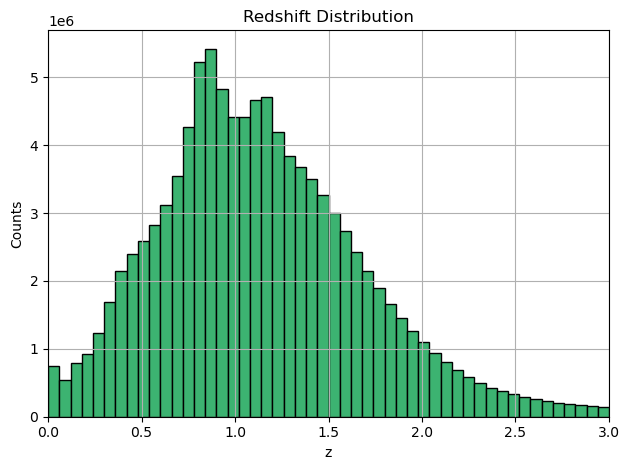

In [20]:
bins = np.linspace(0,3,51)
plt.grid(True)
plt.hist(photoz['z_best'], bins=bins, ec="black", fc="mediumseagreen")
plt.xlabel("z")
plt.ylabel("Counts")
plt.title("Redshift Distribution")
plt.xlim(0,3)
plt.tight_layout()
# marcações mean e rms?

#### Number counts

TypeError: object of type 'float' has no len()

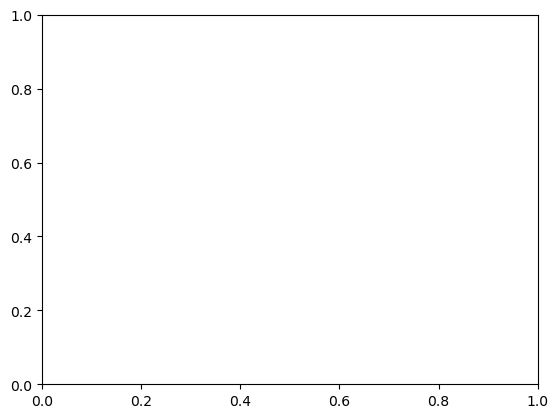

In [7]:
area = 301.74
bins = np.linspace(15,25,21)
#mask = (vac_dp0['mag_i']>10 & vac_dp0['mag_i']<30)

#quantidade de objetos / area

n, bins, patches = plt.hist(vac_dp0['mag_i'], histtype='step', weights=(len(vac_dp0['mag_i'])/area), 
                            bins=bins, color='darkblue')
#print(np.argmax(n))
#print(bins)
maximo = (bins[np.argmax(n)] + bins[np.argmax(n)+1])/2
plt.vlines(maximo, 10e-1, 10e7, linestyles='dotted', color='black')
plt.text(maximo-1, 10e4, maximo, fontsize=11)
plt.xlabel("mag i")
plt.ylabel("$N_{gal} deg^{-2}0.5mag^{-1}$")
plt.xlim(15, 25)
plt.ylim(10e-1, 10e7)
plt.yscale('log')
plt.grid(True)
plt.tight_layout()

#### Mag x z

In [ ]:
for i, band in enumerate(bands):
    pl.figure(figsize=[10,4])
    pl.subplot(121) 
    mag = np.array(dc2[f'mag_{band}'])
    z = np.array(dc2['z_best'])
    mask = (mag>14)&(mag<32)&(z<=2)
    pl.hexbin(z[mask], mag[mask], None,  mincnt=1, cmap='viridis', gridsize=[200,100], bins='log')
    cbar = pl.colorbar()
    pl.xlabel("mag "+band)
    pl.ylabel("redshift")
    pl.grid(True)
    pl.tight_layout()


### Data: 
   #### Catalogs
* Catalogs of WaZP cluster members in DC2 (truth mags, truth z) and DP0 ("observed" mags, photo-z DNF);
* Truth DC2 halo members catalog, used as reference.


In [2]:
#DP0 catalog
wazp_dp0 = Table.read('/archive/user/aguena/cats/dp0/wazp/7038/wazp_membership.fits', format='fits')
#wazp_dp0
print(wazp_dp0.colnames)

['SeqNr', 'ID_CLUSTER_TILE', 'DETECTION_TILE', 'ID_g', 'NMEM_CL', 'PMEM', 'PMEM_ERR', 'MAG', 'RA', 'DEC', 'RA_CL', 'DEC_CL', 'ZP', 'ZP_CL', 'MSTAR_CL', 'mag_bcg', 'FLAG_BCG', 'mag_bcg_cen', 'FLAG_BCG_CEN', 'DCEN', 'DCEN_NORM', 'SNR', 'NGALS', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'mag_j', 'mag_h', 'mag_k', 'zs', 'zs_flag', 'ID_CLUSTER']


In [36]:
#DC2 catalog
wazp_dc2 = Table.read('/archive/user/aguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/wazp/6948/wazp_membership.fits', format='fits')
#wazp_dc2
print(wazp_dc2.colnames)

['SeqNr', 'ID_CLUSTER_TILE', 'DETECTION_TILE', 'ID_g', 'NMEM_CL', 'PMEM', 'PMEM_ERR', 'MAG', 'RA', 'DEC', 'RA_CL', 'DEC_CL', 'ZP', 'ZP_CL', 'MSTAR_CL', 'mag_bcg', 'FLAG_BCG', 'mag_bcg_cen', 'FLAG_BCG_CEN', 'DCEN', 'DCEN_NORM', 'SNR', 'NGALS', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'mag_j', 'mag_h', 'mag_k', 'zs', 'zs_flag', 'ID_CLUSTER']


________
ESSA PARTE NÃO SEI SE FICARIA MELHOR EM UM NOTEBOOK SEPARADO

The truth catalog is a matching between the WaZP clusters catalog and the halos catalog.
For this part of the work, we used ClEvaR, a library to validate cluster detection, to match the catalogs.

In [41]:
from clevar import ClCatalog
from clevar.match import MembershipMatch

In [42]:
# read catalogs
wazp = ClCatalog.read('/archive/user/aguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/wazp/6948/wazp_cluster.fits', 
                      'wazp', tags={'id':'id','ngals':'ngals','zp_bright':'zp_bright'}, full=False)
halo = ClCatalog.read('/archive/user/aguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits', 
                      'halo', tags={'id':'halo_id'}, full=False)
mt = MembershipMatch()
# read matching info
mt.load_matches(wazp, halo, '/archive/user/aguena/notebooks_backup/wazp/dc2/6948/mem_pmem')

wazp
 * Total objects:    298,383
 * multiple (self):  175,031
 * multiple (other): 175,031
 * unique (self):    175,031
 * unique (other):   157,241
 * cross:            155,726

halo
 * Total objects:    454,475
 * multiple (self):  188,953
 * multiple (other): 188,953
 * unique (self):    188,953
 * unique (other):   161,712
 * cross:            155,727


Select richness interval.

In [43]:
mask_25_truth = (wazp['NGALS']>25)&(wazp['NGALS']<35)
mask_35_truth = (wazp['NGALS']>35)&(wazp['NGALS']<50)
mask_50_truth = (wazp['NGALS']>50)

richness_truth = [mask_25_truth, mask_35_truth, mask_50_truth]

Do the matching.

In [44]:
from clevar.match import get_matched_pairs
for i, richness in enumerate(richness_truth):
    wazp_matched, halos_matched = get_matched_pairs(wazp, halo, 'cross', mask1=richness)
    if i == 0:
        halos_matched_25 = halos_matched
    if i == 1:
        halos_matched_35 = halos_matched
    if i == 2:
        halos_matched_50 = halos_matched
        
print(f'25<Ngals<35:{halos_matched_25}\n35<Ngals<50:{halos_matched_35}\nNgals>50:{halos_matched_50}')

25<Ngals<35:halo:
   halo_id    mt_self mt_other ...     mt_frac_self    mt_cross
------------- ------- -------- ... ------------------- --------
1334700157224  298255   298255 ...  0.3228445562195247   298255
 511500189203  298063   298063 ...  0.1451796353438996   298063
4083900078208  297789   297789 ... 0.21414218204752342   297789
  28100020235  297654   297654 ...  0.3168249702969231   297654
 371600166219  297522   297522 ...  0.5495461208853043   297522
 532700099241  296667   296667 ...  0.5542813880681138   296667
2306400048253  296593   296593 ... 0.41442277179124226   296593
2994100060224  296412   296412 ...   0.370645910664524   296412
 355800047230  296069   296069 ... 0.35711891486426217   296069
2271900035235  295956   295956 ... 0.35910093244573604   295956
          ...     ...      ... ...                 ...      ...
 397900151373     550      550 ...   0.289022034444049      550
 857900151338     518      518 ...  0.5212042475142135      518
 766900153355     505 

Nice. We have the halos. Now we need the halo members.

In [45]:
halo_members_path = '/archive/user/aguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/'
halo_members = Table.read(halo_members_path + 'halos_m200c_13.0_members_nfwpmem.fits', format='fits')

In [46]:
halo_members['halo_id'] = halo_members['halo_id'].astype(str)

In [47]:
mem_mask = [HALO_ID in halos_matched_25.id_dict for HALO_ID in halo_members['halo_id']]
truth_25 = halo_members[mem_mask]
print(truth_25.colnames)
#truth_25

mem_mask = [HALO_ID in halos_matched_35.id_dict for HALO_ID in halo_members['halo_id']]
truth_35 = halo_members[mem_mask]
#truth_35

mem_mask = [HALO_ID in halos_matched_50.id_dict for HALO_ID in halo_members['halo_id']]
truth_50 = halo_members[mem_mask]
#truth_50

['galaxyID', 'halo_id', 'halo_mass', 'is_central', 'ra_true', 'dec_true', 'ra', 'dec', 'mag_true_u', 'mag_true_r', 'mag_true_g', 'mag_true_i', 'mag_true_z', 'mag_true_y', 'redshift_true', 'ind_cl', 'dcen_deg', 'dcen_mpc', 'pmem_nfw2d', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri']


In [48]:
truth_richness = [truth_25, truth_35, truth_50]

_______

#### Data selection

Select the catalog (wazp_dc2, wazp_dp0 or truth) and the magnitude bands to plot examples of CMDs and color histograms.

In [5]:
catalog = wazp_dp0

mag1 = 'r'
mag2 = 'i'

Magnitude cut $m_{r}^{*}$

In [6]:
data = np.loadtxt('/archive/user/aguena/cats/dc2/mstar/DC2_z_star.dat')
mstar = spline(*data[data[:,0]<2].T)

In [7]:
mask_mag = (catalog['mag_z']<=mstar(catalog['ZP'])+1.5)

Select the richness intervals.

In [8]:
mask_25 = (catalog['NGALS']>25)&(catalog['NGALS']<35)
mask_35 = (catalog['NGALS']>35)&(catalog['NGALS']<50)
mask_50 = (catalog['NGALS']>50)

richness = [mask_25, mask_35, mask_50]

Arrays to save red fractions and errors

In [9]:
fraction = []
fraction_err = []
photozs = []

### Spacial distribution
Let's compare DP0 and DC2 spacial distribution.

/tmp/ipykernel_4633/3652593794.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


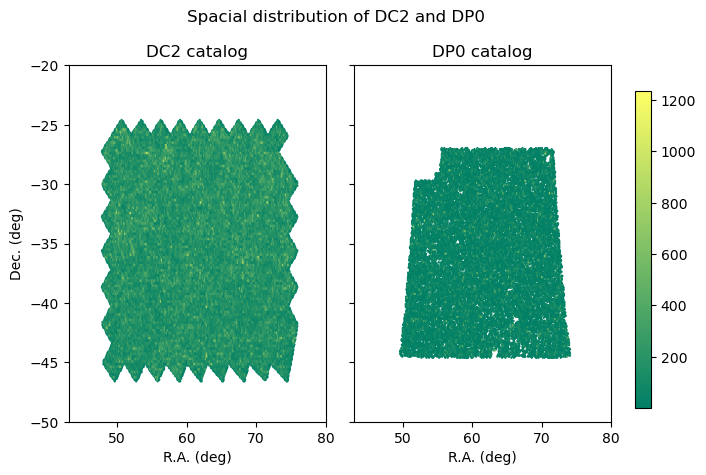

In [44]:
plt.rcParams['font.size'] = 10

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('        Spacial distribution of DC2 and DP0')

ra = wazp_dc2['RA']
ra[ra >180.0] -= 360
dec = wazp_dc2['DEC']

im1 = ax1.hexbin(ra, dec, None,  mincnt=1, cmap='summer', gridsize=[200,100])
ax1.set_title('DC2 catalog')

ra2 = wazp_dp0['RA']
ra2[ra2 >180.0] -= 360
dec2 = wazp_dp0['DEC']

im2 = ax2.hexbin(ra2, dec2, None,  mincnt=1, cmap='summer', gridsize=[200,100])
ax2.set_title('DP0 catalog')

for ax in fig.get_axes():
    ax.set_xlabel("R.A. (deg)")  
    ax.set_ylabel("Dec. (deg)")
    ax.set_xlim(43,80)
    ax.set_ylim(-50,-20)
    ax.label_outer()

#fig.subplots_adjust(right=0.9)
cax = fig.add_axes([1.0, 0.15, 0.025, 0.66])
cbar = fig.colorbar(im1, cax=cax, cmap='summer', orientation='vertical')

plt.tight_layout()
fig.savefig('ra_x_dec_dp0.png')

### Color magnitude diagrams

Select the redshift interval to plot CMDs of the selected catalog.
The name of the columns can vary according the catalog.

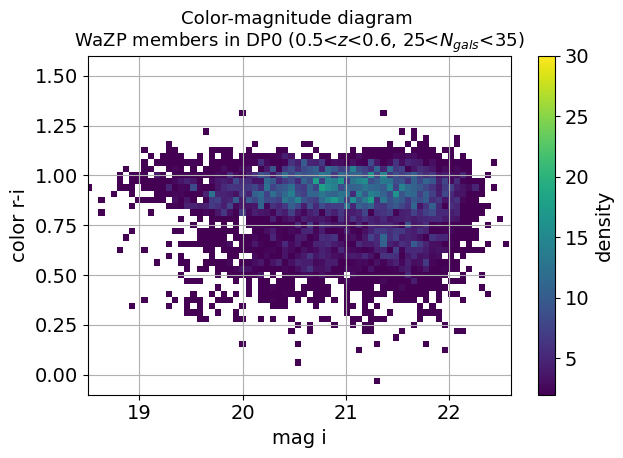

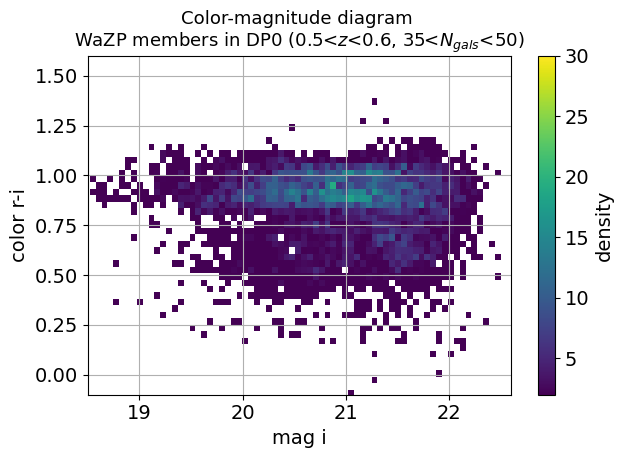

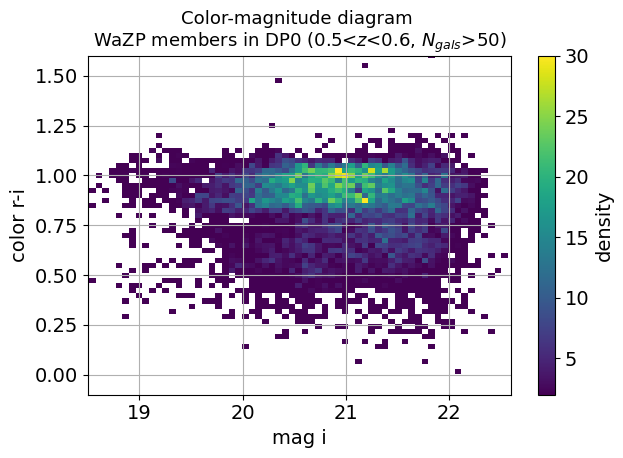

In [15]:
plt.rcParams['font.size'] = 14

zpmax = 0.6
zpmin = 0.5

Nbins = 1
dz = (zpmax - zpmin)/Nbins

for j in range(0, Nbins):
    z1 = zpmin + (j * dz)
    z2 = z1 + dz
    round(z1,1)
    round(z2,1)
    #print(z1, z2)
    
    for i, richness_bins in enumerate(richness):

        mask_z = (catalog['ZP']>z1)&(catalog['ZP']<z2)
        mask = (richness_bins)&(mask_z)&(mask_mag) 

        plt.figure()#, dpi=300)
        catalog_color = catalog[f'mag_{mag1}'][mask] - catalog[f'mag_{mag2}'][mask]
        color = np.array(catalog_color)
        mag = np.array(catalog[f'mag_{mag2}'][mask])
        pmem = np.array(catalog['PMEM'][mask])
        plt.hist2d(mag, color, bins=70, weights=pmem, cmin=0.1, cmax=None, cmap='viridis')
        cbar = pl.colorbar(label="density")

        plt.xlim(18.5, 22.6)
        plt.ylim(-0.1, 1.6)
        plt.clim(2.0, 30.0)
        
        if i == 0:
             text = '25<$N_{gals}$<35'
        if i == 1:
             text='35<$N_{gals}$<50'
        if i == 2:
            text='$N_{gals}$>50'
            
        plt.title(f'Color-magnitude diagram \nWaZP members in DP0 ({round(z1,1)}<$z$<{round(z2,1)}, {text})', fontsize = 13)
        plt.xlabel('mag '+mag2)
        plt.ylabel(f'color {mag1}-{mag2}')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'cmd_dp0_{i}.png')

### Color histograms (DC2 and DP0)
* After selecting the richness range and the magnitudes, we have to separate the data in redshift bins.
* The red and blue populations were characterized by Gaussian distributions on color histograms. We chose the colors that envelop the 4000 Å break. The 4000 Å break is caused by the absorption of high energy radiation from metals in stellar atmospheres and by a deficiency of hot, blue stars. That implies the presence of old stellar populations.
    We have the following distribution of colors: $0.1 < z < 0.2$ in g-r, $0.3 < z < 0.6$ in r-i, $0.7 < z < 1.0$ in i-z, $1.1 < z < 1.4$ in z-y.

* We integrated the curves to find the number of red and total members and calculate the red fraction in each redshift bin.

Define gaussian fit and integral.

Gaussian params: A, $\mu$ and $\sigma$ are the height, the mean and the standard deviation, respectively.

In [10]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [11]:
def gauss_integral(y):
    return A2*np.exp(-(y-mu2)**2/2/sigma2**2)
def gauss2_integral(y):
    return (A1*np.exp(-(y-mu1)**2/2/sigma1**2)+A2*np.exp(-(y-mu2)**2/2/sigma2**2))

Select redshift interval.

In [18]:
z1 = 0.5
z2 = 0.6

Plot color histograms and fit gaussians for selected redshift bin.

First, let's see some exemple of color histograms, with 0.5<z<0.6.

            params        err
mu1       0.630949   0.008358
sigma1    0.111868   0.008393
A1      303.692747  12.470350
mu2       0.930792   0.002252
sigma2    0.089573   0.002087
A2      999.235646  14.197400


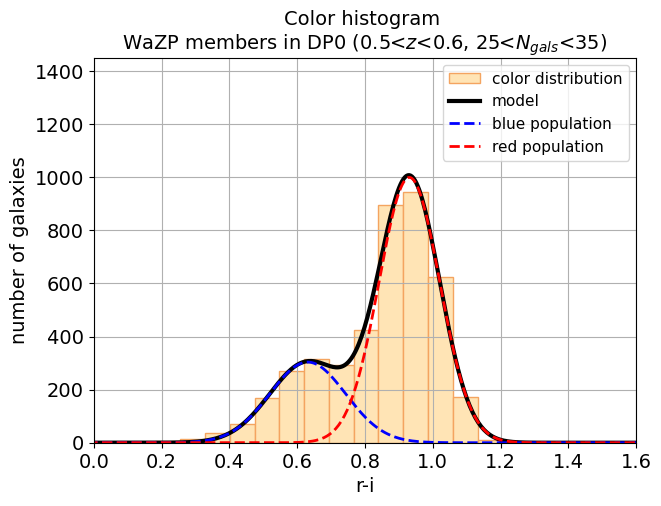

            params        err
mu1       0.630009   0.006722
sigma1    0.109946   0.006727
A1      275.076394   9.249265
mu2       0.930298   0.001686
sigma2    0.091001   0.001573
A2      991.311380  10.295870


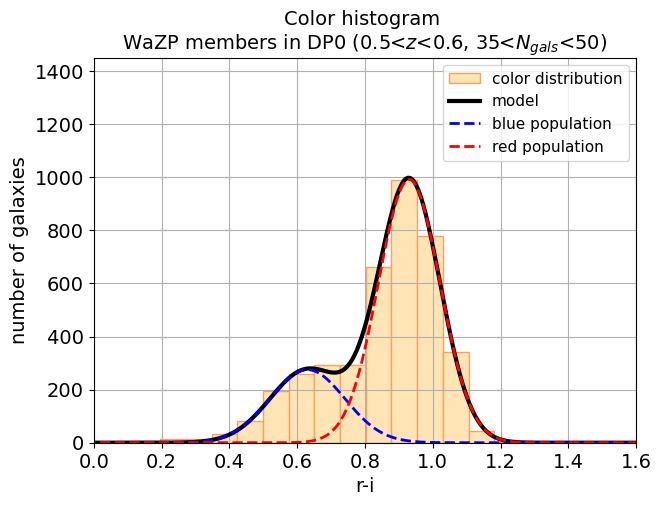

             params        err
mu1        0.653785   0.040063
sigma1     0.136611   0.036073
A1       336.494774  39.994783
mu2        0.945992   0.006929
sigma2     0.089204   0.005702
A2      1343.908938  70.538210


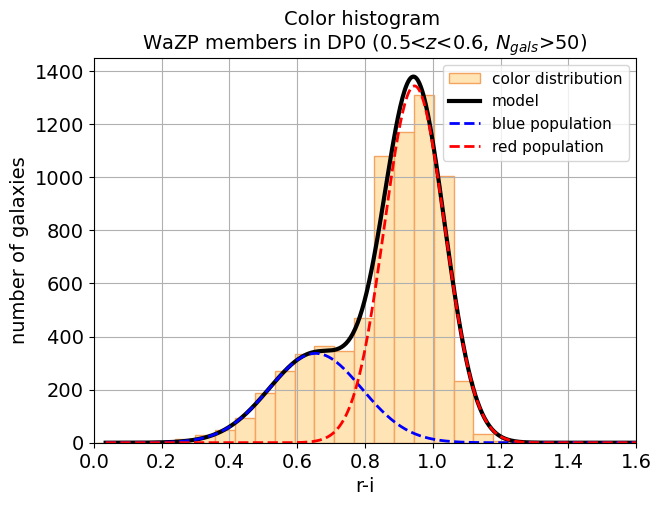

In [19]:
catalog_color = catalog[f'mag_{mag1}'] - catalog[f'mag_{mag2}']
mask_z = (catalog['ZP']>z1)&(catalog['ZP']<z2)

for i, richness_bins in enumerate(richness): 
    
    mask = (richness_bins)&(mask_z)&(mask_mag) 
    
    color = np.array(catalog_color[mask])
    pmem = np.array(catalog['PMEM'][mask])

    plt.figure(figsize=[7,5])
    y,x,_=plt.hist(color, bins=30, weights=pmem, fc="moccasin", ec='sandybrown', label='color distribution')
    x=(x[1:]+x[:-1])/2

    expected = (0.6, 0.2, 1000.0, 0.9, 0.1, 3000.0)
    params, cov = curve_fit(bimodal, x, y, expected)
    sigma=np.sqrt(np.diag(cov))
    x_fit = np.linspace(x.min(), x.max(), 500)

    plt.plot(x_fit, bimodal(x_fit, *params), color='black', lw=3, label='model')
    plt.plot(x_fit, gauss(x_fit, *params[0:3]), color='blue', lw=2, ls="--", label='blue population')
    plt.plot(x_fit, gauss(x_fit, *params[3:6]), color='red', lw=2, ls="--", label='red population')

    if i == 0:
        text = '25<$N_{gals}$<35'
    if i == 1:
        text='35<$N_{gals}$<50'
    if i == 2:
        text='$N_{gals}$>50'
            
    plt.title(f'Color histogram \nWaZP members in DP0 ({round(z1,1)}<$z$<{round(z2,1)}, {text})', fontsize=14)
    plt.legend(fontsize=11)
    plt.ylabel('number of galaxies')
    plt.xlim(0.0, 1.6)
    plt.ylim(0.0, 1450)
    plt.xlabel(f'{mag1}-{mag2}')
    plt.grid(True)
    data = pd.DataFrame(data={'params': params, 'err': sigma}, index=bimodal.__code__.co_varnames[1:])
    print(data)

    plt.savefig(f'color_hist_{i}.png')
    plt.show() 

    #fazer txt para guardar esses parâmetros
    mu1 = data.to_numpy()[0][0]
    sigma1 = data.to_numpy()[1][0]
    A1 = data.to_numpy()[2][0]
    mu2 = data.to_numpy()[3][0]
    sigma2 = data.to_numpy()[4][0]
    A2 = data.to_numpy()[5][0]

    mu1_err = data.to_numpy()[0][1]
    sigma1_err = data.to_numpy()[1][1]
    A1_err = data.to_numpy()[2][1]
    mu2_err = data.to_numpy()[3][1]
    sigma2_err = data.to_numpy()[4][1]
    A2_err = data.to_numpy()[5][1]

For other redshift bins (and other colors), repeat the process below.

Select color.

TESTE : PRIMEIRO SÓ PRA DP0 25-35 COR R-I

In [12]:
mag1 = 'r'
mag2 = 'i'

Select the redshift bin.

In [13]:
z1 = 0.1
z2 = 0.2

Select the richness bin.

In [14]:
richness_bin = mask_25

TENTANDO DEIXAR MAIS AUTOMÁTICO A PRODUÇÃO DAS GAUSSIANAS NOS HISTOGRAMAS
não consigo fazer o programa ler os parâmetros esperados

Expected params for the Gaussian fit.

In [ ]:
#dicionário??? documento txt??

In [23]:
#DP0 r-i 25-35
expected = [("0.4", "0.05", "2000.0", "0.5", "0.2", "3000.0"),
(0.5, 0.3, 50.0, 0.7, 0.1, 400.0),
(0.5, 0.3, 50.0, 0.7, 0.1, 400.0),
(0.5, 0.3, 50.0, 0.7, 0.1, 400.0),
(0.5, 0.3, 50.0, 0.7, 0.1, 400.0),
(0.5, 0.3, 50.0, 0.7, 0.1, 400.0),
(0.7, 0.2, 800.0, 1.2, 0.2, 1000.0),
(0.7, 0.2, 800.0, 1.2, 0.2, 1000.0),
(0.7, 0.2, 800.0, 1.2, 0.2, 1000.0),
(0.5, 0.2, 800.0, 1.0, 0.2, 1000.0),
(0.5, 0.2, 800.0, 1.0, 0.2, 1000.0),
(0.5, 0.2, 800.0, 1.0, 0.2, 1000.0),
(0.5, 0.2, 800.0, 1.0, 0.2, 1000.0)]

IndexError: string index out of range

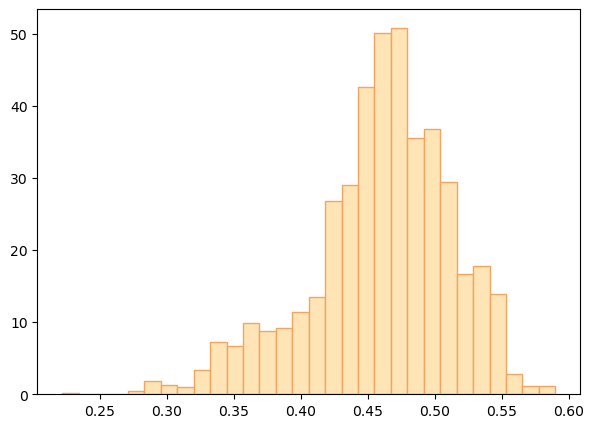

In [25]:
zpmax = 1.5
zpmin = 0.0

Nbins = int(10*(zpmax-zpmin))
dz = (zpmax - zpmin)/Nbins

for j in range(0, Nbins):
    z1 = (j * dz) + 0.1
    z2 = z1 + dz
    z1 = round(z1,1)
    z2 = round(z2,1)
    
    catalog_color = catalog[f'mag_{mag1}'] - catalog[f'mag_{mag2}']

    mask_z = (catalog['ZP']>z1)&(catalog['ZP']<z2)
    mask = (richness_bin)&(mask_z)&(mask_mag) 

    color = np.array(catalog_color[mask])
    pmem = np.array(catalog['PMEM'][mask])

    plt.figure(figsize=[7,5])
    y,x,_=plt.hist(color, bins=30, weights=pmem, fc="moccasin", ec='sandybrown', label='color distribution')
    x=(x[1:]+x[:-1])/2

    mu1 = expected[j][0]
    sigma1 = expected[j][1]
    A1 = expected[j][2]
    mu2 = expected[j][3]
    sigma2 = expected[j][4]
    A2 = expected[j][5]
    
    expected = float(mu1, sigma1, A1, mu2, sigma2, A2)
    #expected = (0.35, 0.05, 10.0, 0.47, 0.2, 50.0)
    params, cov = curve_fit(bimodal, x, y, expected)
    sigma=np.sqrt(np.diag(cov))
    x_fit = np.linspace(x.min(), x.max(), 500)

    plt.plot(x_fit, bimodal(x_fit, *params), color='black', lw=3, label='model')
    plt.plot(x_fit, gauss(x_fit, *params[0:3]), color='blue', lw=2, ls="--", label='blue population')
    plt.plot(x_fit, gauss(x_fit, *params[3:6]), color='red', lw=2, ls="--", label='red population')
    plt.title(f'Color histogram \nWaZP members in DP0 ({round(z1,1)}<$z$<{round(z2,1)})', fontsize=14)
    plt.legend(fontsize=11)
    plt.ylabel('number of galaxies')
    plt.xlabel(f'{mag1}-{mag2}')
    plt.grid(True)
    data = pd.DataFrame(data={'params': params, 'err': sigma}, index=bimodal.__code__.co_varnames[1:])
    print(data)
    plt.show() 

    #fazer txt para guardar esses parâmetros
    mu1 = data.to_numpy()[0][0]
    sigma1 = data.to_numpy()[1][0]
    A1 = data.to_numpy()[2][0]
    mu2 = data.to_numpy()[3][0]
    sigma2 = data.to_numpy()[4][0]
    A2 = data.to_numpy()[5][0]

    mu1_err = data.to_numpy()[0][1]
    sigma1_err = data.to_numpy()[1][1]
    A1_err = data.to_numpy()[2][1]
    mu2_err = data.to_numpy()[3][1]
    sigma2_err = data.to_numpy()[4][1]
    A2_err = data.to_numpy()[5][1]
    

In [ ]:
out = np.transpose([mu1, sigma1, A1, mu2, sigma2, A2, mu1_err, sigma1_err, A1_err, mu2_err, sigma2_err, A2_err])
name = f'params_{z1}.txt'
np.savetxt(name, out, header='', fmt='%1.6e')

### Color histograms (truth catalog)

The color histogram of the truth catalog is a bit different, because the red population in this case is the Gaussian that characterizes the "is on red sequence" column. 

Again, first let's see some examples.

In [49]:
mag1 = 'r'
mag2 = 'i'
z1 = 0.5
z2 = 0.6

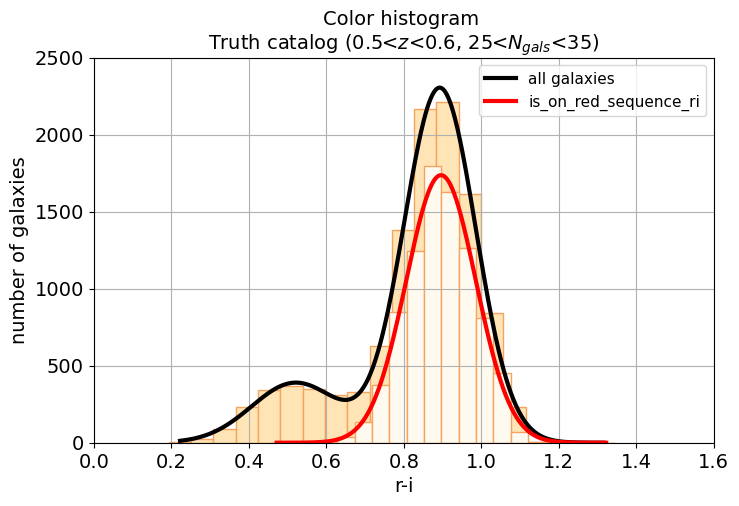

             params        err
mu1        0.520673   0.007425
sigma1     0.113505   0.008089
A1       389.686600  20.212805
mu2        0.892800   0.001149
sigma2    -0.092649   0.001202
A2      2303.902058  22.025175
        params red   err red
mu        0.896109 -0.092649
sigma     0.089845 -0.092649
A      1737.414331 -0.092649


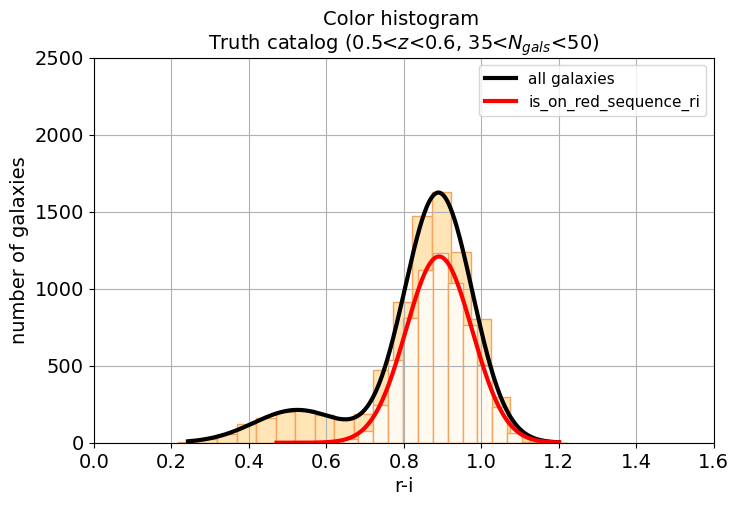

             params        err
mu1        0.524802   0.011986
sigma1     0.112316   0.013092
A1       212.834755  18.308273
mu2        0.889471   0.001404
sigma2    -0.087194   0.001463
A2      1623.453406  20.406706
        params red   err red
mu        0.890987 -0.087194
sigma     0.085181 -0.087194
A      1209.363441 -0.087194


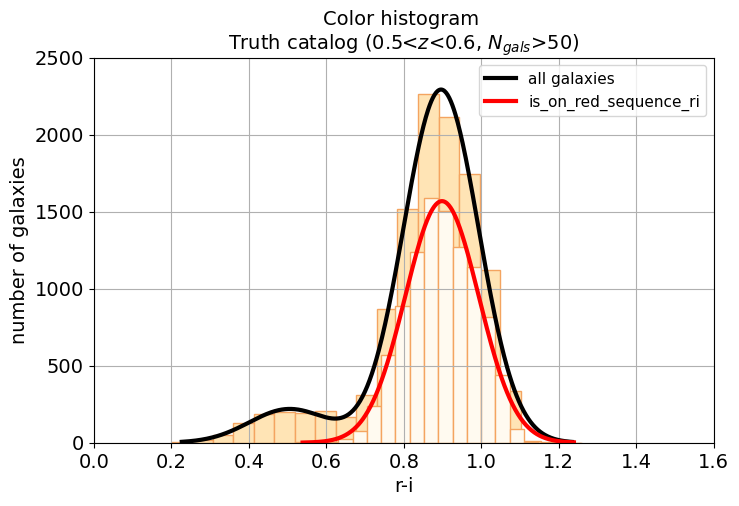

             params        err
mu1        0.504535   0.027349
sigma1    -0.103134   0.029053
A1       218.841150  48.371213
mu2        0.896202   0.002538
sigma2    -0.097047   0.002675
A2      2293.164697  49.712480
        params red   err red
mu        0.898690 -0.097047
sigma     0.094785 -0.097047
A      1568.695094 -0.097047


In [50]:
for i, truth in enumerate(truth_richness): 

    mask_z = (truth['redshift_true']>z1)&(truth['redshift_true']<z2)
    mask_isred = (truth[f'is_on_red_sequence_{mag1}{mag2}']==True)
    mask = (mask_z)
    mask2 = (mask_z)&(mask_isred)

    truth_color = truth[f'mag_true_{mag1}'][mask] - truth[f'mag_true_{mag2}'][mask]
    color = np.array(truth_color)
    pmem = np.array(truth['pmem_nfw2d'][mask])

    truth_color2 = truth[f'mag_true_{mag1}'][mask2] - truth[f'mag_true_{mag2}'][mask2]
    color2 = np.array(truth_color2)
    pmem2 = np.array(truth['pmem_nfw2d'][mask2])

    plt.figure(figsize=[8,5])
    y,x,_=plt.hist(color, bins=20, weights=pmem, fc="moccasin", ec='sandybrown')
    x=(x[1:]+x[:-1])/2
    expected = (0.5, 0.2, 20.0, 0.9, 0.2, 400.0)
    params, cov = curve_fit(bimodal, x, y, expected)
    sigma=np.sqrt(np.diag(cov))
    x_fit = np.linspace(x.min(), x.max(), 500)


    y2,x2,_2=plt.hist(color2, bins=20, weights=pmem2, fc='floralwhite', ec='sandybrown')
    x2=(x2[1:]+x2[:-1])/2
    expected2 = (1.0, 0.2, 4000.0)
    params2, cov2 = curve_fit(gauss, x2, y2, expected2)
    sigma2=np.sqrt(np.diag(cov2))
    x_fit2 = np.linspace(x2.min(), x2.max(), 500)
    
    if i == 0:
        text = '25<$N_{gals}$<35'
    if i == 1:
        text='35<$N_{gals}$<50'
    if i == 2:
        text='$N_{gals}$>50'

    plt.plot(x_fit, bimodal(x_fit, *params), color='black', lw=3, label='all galaxies')
    plt.plot(x_fit2, gauss(x_fit2, *params2), color='red', lw=3, label=f'is_on_red_sequence_{mag1}{mag2}')
    plt.title(f'Color histogram \nTruth catalog ({round(z1,1)}<$z$<{round(z2,1)}, {text})', fontsize=14)
    plt.legend(fontsize=11)
    plt.ylabel('number of galaxies')
    plt.xlabel(f'{mag1}-{mag2}')
    plt.xlim(0.0, 1.6)
    plt.ylim(0.0, 2500)
    plt.grid(True)

    plt.savefig(f'color_hist_halos_{i}.png')
    plt.show() 

    data = pd.DataFrame(data={'params': params, 'err': sigma}, index=bimodal.__code__.co_varnames[1:])
    print(data)

    mu1 = data.to_numpy()[0][0]
    sigma1 = data.to_numpy()[1][0]
    A1 = data.to_numpy()[2][0]
    mu2 = data.to_numpy()[3][0]
    sigma2 = data.to_numpy()[4][0]
    A2 = data.to_numpy()[5][0]

    mu1_err = data.to_numpy()[0][1]
    sigma1_err = data.to_numpy()[1][1]
    A1_err = data.to_numpy()[2][1]
    mu2_err = data.to_numpy()[3][1]
    sigma2_err = data.to_numpy()[4][1]
    A2_err = data.to_numpy()[5][1]

    data2 = pd.DataFrame(data={'params red': params2, 'err red': sigma2}, index=gauss.__code__.co_varnames[1:])
    print(data2)

    mu = data.to_numpy()[0][0]
    sigma = data.to_numpy()[1][0]
    A = data.to_numpy()[2][0]

    mu_err = data.to_numpy()[0][1]
    sigma_err = data.to_numpy()[1][1]
    A_err = data.to_numpy()[2][1]


Propagating errors according to the general equation:
$err_{w}^2 = \left(\frac{\partial w}{\partial x}\right)^2 err_{x}^2 + \left(\frac{\partial w}{\partial y}\right)^2 err_{y}^2 + \left(\frac{\partial w}{\partial z}\right)^2 err_{z}^2 + ...$


erro1 -> $\left(\frac{\partial w}{\partial x}\right)^2 err_{x}^2 = \left(\frac{\partial}{\partial A}  \int_{x_{min}}^{x_{max}} A e^{\frac{-(x-\mu)^2}{2\sigma ^2}}\right)^2 err_{A}^2 =\left(\sqrt{\frac{\pi}{2}}\, \sigma \, erf\left(\frac{x-\mu}{\sigma \sqrt{2}}\right)\right)^2 err_{A}^2$


erro2 -> $\left(\frac{\partial w}{\partial y}\right)^2 err_{y}^2 = \left(\frac{\partial}{\partial \mu}  \int_{x_{min}}^{x_{max}} A e^{\frac{-(x-\mu)^2}{2\sigma ^2}}\right)^2 err_{\mu}^2 = \left(-A e^{\frac{-(\mu-x)^2}{2\sigma ^2}}\right)^2 \, err_{\mu}^2$

erro3 -> $\left(\frac{\partial w}{\partial z}\right)^2 err_{z}^2 =
     \left(\frac{\partial}{\partial \sigma}  \int_{x_{min}}^{x_{max}} A e^{\frac{-(x-\mu)^2}{2\sigma ^2}}\right)^2 err_{\sigma}^2 = \left(\frac{A(\mu - x) e^{\frac{-(x-\mu)^2}{2\sigma ^2}}}{\sigma} - \sqrt{\frac{\pi}{2}} \, A \, erf\left(\frac{\mu - x}{\sigma \sqrt{2}}\right)\right)^2 err_{\sigma}^2$
     


_____________________________________________
AINDA PRECISO ATUALIZAR A PARTIR DAQUI

In [ ]:
erro1 = ((np.sqrt(np.pi/2))*sigma2*erf((mu2-x.max())/(sigma2*np.sqrt(2)))) - ((np.sqrt(np.pi/2))*sigma2*erf((mu2-x.min())/(sigma2*np.sqrt(2))))
erro1 = (erro1**2) * (A2_err)**2
print(erro1)

erro2 = (-A2* np.exp(-(mu2-x.max())**2/2/sigma2**2)) - (-A2* np.exp(-(mu2-x.min())**2/2/sigma2**2))
erro2 = (erro2**2) * (mu2_err)**2
print(erro2)

erro3_1 = ((A2*(mu2-x.max()* np.exp(-(mu2-x.max())**2/2/sigma2**2)))/(sigma2) -A2*np.sqrt(np.pi/2)*erf((mu2-x.max())/(sigma2*np.sqrt(2))))
erro3_2 = ((A2*(mu2-x.min()* np.exp(-(mu2-x.min())**2/2/sigma2**2)))/(sigma2) -A2*np.sqrt(np.pi/2)*erf((mu2-x.min())/(sigma2*np.sqrt(2))))
erro3 = erro3_1 - erro3_2
erro3 = (erro3**2) * (sigma2_err)**2
print(erro3)

#erro gaussiana vermelha
erro_r = np.sqrt(erro1+erro2+erro3)
print(erro_r)

erro4 = ((np.sqrt(np.pi/2))*sigma1*erf((mu1-x.max())/(sigma1*np.sqrt(2)))) - ((np.sqrt(np.pi/2))*sigma1*erf((mu1-x.min())/(sigma1*np.sqrt(2))))
erro4 = (erro4**2) * (A1_err)**2
print(erro4)

erro5 = (-A1* np.exp(-(mu1-x.max())**2/2/sigma1**2)) - (-A1* np.exp(-(mu1-x.min())**2/2/sigma1**2))
erro5 = (erro5**2) * (mu1_err)**2
print(erro2)

erro6_1 = ((A1*(mu1-x.max()* np.exp(-(mu1-x.max())**2/2/sigma1**2)))/(sigma1) -A1*np.sqrt(np.pi/2)*erf((mu1-x.max())/(sigma1*np.sqrt(2))))
erro6_2 = ((A1*(mu1-x.min()* np.exp(-(mu1-x.min())**2/2/sigma1**2)))/(sigma1) -A1*np.sqrt(np.pi/2)*erf((mu1-x.min())/(sigma1*np.sqrt(2))))
erro6 = erro6_1 - erro6_2
erro6 = (erro6**2) * (sigma1_err)**2
print(erro6)

#erro gaussiana azul
erro_b = np.sqrt(erro4+erro4+erro6)
print(erro_b)

#erro gaussiana total
erro = np.sqrt(erro1+erro2+erro3+erro4+erro4+erro6)
print(erro)

General results:

In [ ]:
print(f'{round(z1,1)}<z<{round(z2,1)}')
n_red_galaxies, n_red_galaxies_err = quad(gauss_integral, x.min(), x.max())
print(f'number of red galaxies:{n_red_galaxies} +- {erro_v}')
n_galaxies, n_galaxies_err = quad(gauss2_integral, x.min(), x.max())
print(f'number of galaxies:{n_galaxies} +- {erro}')
red_fraction = n_red_galaxies/n_galaxies
red_fraction_err = (n_red_galaxies/n_galaxies)* np.sqrt((erro_v/n_red_galaxies)**2+(erro/n_galaxies)**2)
print(f'red fraction:{red_fraction} +- {red_fraction_err}')

Save fractions in a txt file.

In [ ]:
fraction.append(red_fraction)
fraction_err.append(red_fraction_err)
photozs.append(photoz)

In [ ]:
out = np.transpose([photozs, fraction, fraction_err])
name = 'dp0_fractions.txt' #change the name of the catalog.
np.savetxt(name, out, header='redshift   fractions   errors', fmt='%1.6e')

## Preliminary Results:

Plot a figure to see the evolution of red fraction with redshift for the sample analyzed.


In [ ]:
#read file
doc = 'dp0_fractions.txt'
redshifts1, fractions1, fractions_err1= np.loadtxt(doc, usecols=(0,1,2), unpack=True)
doc2 = 'dp0_fractions_35.txt'
redshifts2, fractions2, fractions_err2= np.loadtxt(doc2, usecols=(0,1,2), unpack=True)
doc3 = 'dp0_fractions_50.txt'
redshifts3, fractions3, fractions_err3= np.loadtxt(doc3, usecols=(0,1,2), unpack=True)

#dados do is_on_red_sequence
fractions = [0.5921440352216439,
 0.4642129461578483,
 0.4789826401939994,
 0.6606916236992021,
 0.641815640391323,
 0.44747444997980507,
 0.651031839816072,
 0.5323493468171591,
 0.5322468325080284,
 0.4176714023569384,
 0.4403604511825388,
 0.42375264278427704,
 0.3133637322335352]

fractions_err = [0.1472829857276373,
 0.03801613952846332,
 0.04836953657826101,
 0.026204572223403992,
 0.022289734202544854,
 0.02229797364575938,
 0.03471092178715547,
 0.03341395373284115,
 0.022290112387518414,
 0.01901494321516365,
 0.030791916110973,
 0.01509076032375121,
 0.024954069152175483]

plt.rcParams['font.size'] = 15

plt.figure(figsize=[6,6], dpi=300)

plt.plot(redshifts1, fractions1, 'o', color='green', label='25<Ngals<35')
plt.errorbar(redshifts1, fractions1, yerr=fractions_err1, color='green', fmt='.')
plt.plot(redshifts2, fractions2, 's', color='yellowgreen', label='35<Ngals<50')
plt.errorbar(redshifts2, fractions2, yerr=fractions_err2, color='yellowgreen', fmt='.')
plt.plot(redshifts3, fractions3, 'x', color='teal', label='Ngals>50')
plt.errorbar(redshifts3, fractions3, yerr=fractions_err3, color='teal', fmt='.')
plt.plot(redshifts3, fractions, '^', color='black', label='"is_on_red_sequence_ri"')
plt.errorbar(redshifts3, fractions, yerr=fractions_err, color='black', fmt='.')
plt.xlabel("redshift")
plt.ylabel("red fraction")
plt.ylim(-0.1, 1.2)
plt.xlim(0.1, 1.4)
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3])
plt.yticks([0.0, 0.4, 0.8, 1.2])
plt.title("Red fraction in WaZP DP0 clusters (color r-i)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('dp0.png')


## Discussion:
* The first and last redshift bins have larger error bars because fewer objects are selected and the gaussian fit is not so precise.
* The red fraction evolution observed in wazp cluster members recovers the overall trend of the galaxies marked as "is on red sequence" in the truth catalog for color r-i.
* The reasonable agreement between DC2 and DP0 results shows that introducing photo-z-related uncertainties in the WaZP cluster detection does not change the overall trend of red fraction evolution.

## Conclusions:

* As WaZP does not rely on the red sequence information, its good performance in detecting clusters with a low fraction of red galaxies makes the algorithm suitable for studies of cluster properties at high redshifts.
* In future works, we intend to investigate the evolution of the red slope.

## Future Works:


We have some preliminar results in the investigation of the inclination of the red sequence - the red slope.

In [ ]:
def green_valley(mu1, sigma1, A1, mu2, sigma2, A2):
    g_pos = ((mu1*sigma2**2 - mu2*sigma1**2)+np.sqrt((mu1*sigma2**2 - mu2*sigma1**2)**2 - (sigma2**2-sigma1**2)*(sigma2**2*mu1**2 - sigma1**2*mu2**2 -2*sigma1**2*sigma2**2*np.log(A1/A2))))/(sigma2**2-sigma1**2)
    g_neg = ((mu1*sigma2**2 - mu2*sigma1**2)-np.sqrt((mu1*sigma2**2 - mu2*sigma1**2)**2 - (sigma2**2-sigma1**2)*(sigma2**2*mu1**2 - sigma1**2*mu2**2 -2*sigma1**2*sigma2**2*np.log(A1/A2))))/(sigma2**2-sigma1**2)
    
    return (g_pos, g_neg)

def redseq_fit(mag, color):
    fit_result = stats.linregress(mag, color)
    a = fit_result.slope
    b = fit_result.intercept
    a_err = fit_result.stderr
    xfit = np.arange(10, 30, 1)
    yfit = a*xfit + b
    
    return a, b, a_err, xfit, yfit

wazp_membership_color = wazp_membership[f'mag_true_{mag1}'][mask] - wazp_membership[f'mag_true_{mag2}'][mask]
color = np.array(wazp_membership_color)
mag = np.array(wazp_membership[f'mag_true_{mag2}'][mask])
pmem = np.array(wazp_membership['pmem_nfw2d'][mask])

x = color.reshape(-1, 1)

green_line1, green_line2 = green_valley(mu1, sigma1, A1, mu2, sigma2, A2)
#if z1==1.0 or z1==1.1 or z1==1.2 or z1==1.3:
#    green_line = green_line2
#else:
green_line = green_line1

plt.rcParams['font.size'] = 15

plt.figure(figsize=[6,6], dpi=300)
#plt.subplot(121) 
plt.hist2d(mag, color, bins=70, weights=pmem, cmin=0.5, cmax=None, cmap='viridis')
cbar = pl.colorbar()

red = (color>=green_line)
# first fit
a1, b1, a1_err, xfit1, yfit1 = redseq_fit(mag[red], color[red])
c1 = np.mean(mag)
b2 = green_line - a1*c1
y2 = a1*xfit1 + b2
plt.plot(xfit1, yfit1, 'r--', lw=1.0)
plt.plot(xfit1, y2, 'g-', lw=1.0)

red2 = (color>=((a1*mag)+b2))
# second fit
a, b, a_err, xfit, yfit = redseq_fit(mag[red2], color[red2])
slope.append(a)
slope_err.append(a_err)
plt.plot(xfit, yfit, 'r-', lw=1.5, label=f'red slope {round(a,5)} +- {round(a_err,5)}')
plt.hlines(green_line, 16.5, 24.5, linestyles='dashed', color='green')
    
plt.title(f'Red sequence fit for {round(z1,1)}<z<{round(z2,1)}')
plt.xlabel('mag '+mag2)
plt.ylabel(f'{mag1}-{mag2}')
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()

## Acknowledgement: 
I would like to thank J. Gschwend, M. Aguena, C. Benoist and L. da Costa for the supervision and LSST Corporation for the financial support.